<a href="https://colab.research.google.com/github/git4sudo/fin_rl_vs_llm/blob/main/compare_with_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
!pip install swig
!pip install wrds
!pip install pyportfolioopt
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-3dmc5rqk
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-3dmc5rqk
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit d2b0d88a71e8058646d41c2eb0eb29d70e258997
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-f2jkh5lw/elegantrl_a8c99bfbea18403ca2cc00fc96ed8089
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-f2jkh5lw/elegantrl_a8c99bfbea18403ca2cc00fc96ed8089
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 155f07fcfe2d0f0a0318f820e8e2f2401ff30eca
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS
import itertools
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

In [ ]:
TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2020-01-01'
TRADE_START_DATE = '2020-01-01'
TRADE_END_DATE = '2024-01-01'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
symbols = [
    'aapl','ba','amzn','dis','msft','ccl','nvda','wmt','bac','sbux'
]

In [ ]:
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                                end_date = TRADE_END_DATE,
                                ticker_list = symbols).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (60370, 8)


In [ ]:
df_raw.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day
0,2000-01-03,0.936384,1.004464,0.907924,0.844981,535796800,aapl,0
1,2000-01-03,4.075000,4.478125,3.952344,4.468750,322352000,amzn,0
2,2000-01-03,41.437500,41.687500,39.812500,25.940290,2638200,ba,0
3,2000-01-03,25.125000,25.125000,24.000000,12.946370,13705800,bac,0
4,2000-01-03,46.000000,47.125000,45.250000,28.774668,1532600,ccl,0


In [ ]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[*********************100%%**********************]  1 of 1 completed

Successfully added technical indicators


Shape of DataFrame:  (6036, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
processed

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2000-01-03,0.936384,1.004464,0.907924,0.844981,535796800,aapl,0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,0.844981,0.844981,24.209999,0.000000
1,2000-01-03,4.075000,4.478125,3.952344,4.468750,322352000,amzn,0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,4.468750,4.468750,24.209999,0.000000
2,2000-01-03,41.437500,41.687500,39.812500,25.940290,2638200,ba,0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,25.940290,25.940290,24.209999,0.000000
3,2000-01-03,25.125000,25.125000,24.000000,12.946370,13705800,bac,0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,12.946370,12.946370,24.209999,0.000000
4,2000-01-03,46.000000,47.125000,45.250000,28.774668,1532600,ccl,0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,28.774668,28.774668,24.209999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60355,2023-12-28,90.089996,90.980003,89.970001,90.400002,8479600,dis,3,0.245315,94.192660,89.735047,51.717656,-131.472305,1.737710,92.652751,88.158208,12.470000,0.773413
60356,2023-12-28,375.369995,376.459991,374.160004,374.587280,14327000,msft,3,2.668700,377.711291,366.355744,58.167714,44.673886,23.578481,373.178901,355.870526,12.470000,0.773413
60357,2023-12-28,496.429993,498.839996,494.119995,495.196777,24658700,nvda,3,6.927852,507.264031,451.336775,56.171622,87.376637,21.097066,482.416306,463.570169,12.470000,0.773413
60358,2023-12-28,95.500000,95.970001,95.110001,95.356293,4518300,sbux,3,-1.057010,98.969987,93.588490,46.833961,-74.817933,25.099002,98.526552,96.783740,12.470000,0.773413


In [ ]:
processed

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2000-01-03,0.936384,1.004464,0.907924,0.844981,535796800,aapl,0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,0.844981,0.844981,24.209999,0.000000
1,2000-01-03,4.075000,4.478125,3.952344,4.468750,322352000,amzn,0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,4.468750,4.468750,24.209999,0.000000
2,2000-01-03,41.437500,41.687500,39.812500,25.940290,2638200,ba,0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,25.940290,25.940290,24.209999,0.000000
3,2000-01-03,25.125000,25.125000,24.000000,12.946370,13705800,bac,0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,12.946370,12.946370,24.209999,0.000000
4,2000-01-03,46.000000,47.125000,45.250000,28.774668,1532600,ccl,0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,28.774668,28.774668,24.209999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60355,2023-12-28,90.089996,90.980003,89.970001,90.400002,8479600,dis,3,0.245315,94.192660,89.735047,51.717656,-131.472305,1.737710,92.652751,88.158208,12.470000,0.773413
60356,2023-12-28,375.369995,376.459991,374.160004,374.587280,14327000,msft,3,2.668700,377.711291,366.355744,58.167714,44.673886,23.578481,373.178901,355.870526,12.470000,0.773413
60357,2023-12-28,496.429993,498.839996,494.119995,495.196777,24658700,nvda,3,6.927852,507.264031,451.336775,56.171622,87.376637,21.097066,482.416306,463.570169,12.470000,0.773413
60358,2023-12-28,95.500000,95.970001,95.110001,95.356293,4518300,sbux,3,-1.057010,98.969987,93.588490,46.833961,-74.817933,25.099002,98.526552,96.783740,12.470000,0.773413


In [ ]:
emotions=pd.read_csv('/content/stocks_processed_data.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
emotions.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,date,open,high,low,close,volume,tic,day,macd,...,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,emo_label,senti_label
0,0,2000-01-03,-0.782505,-0.781243,-0.783308,-0.714637,2.644707,aapl,0,-0.088967,...,-0.721376,-6.081124,-0.750238,4.649049,0.844981,0.844981,0.485454,-0.669293,disgust,bearish
1,1,2000-01-03,-0.734109,-0.728316,-0.735768,-0.658409,1.409771,amzn,0,-0.088967,...,-0.721376,-6.081124,-0.750238,4.649049,4.468750,4.468750,0.485454,-0.669293,disgust,bearish
2,2,2000-01-03,-0.157996,-0.161363,-0.175805,-0.325245,-0.440011,ba,0,-0.088967,...,-0.721376,-6.081124,-0.750238,4.649049,25.940277,25.940277,0.485454,-0.669293,disgust,bearish
3,3,2000-01-03,-0.409527,-0.413723,-0.422720,-0.526866,-0.375977,bac,0,-0.088967,...,-0.721376,-6.081124,-0.750238,4.649049,12.946365,12.946365,0.485454,-0.669293,optimism,bearish
4,4,2000-01-03,-0.087645,-0.078512,-0.090897,-0.281266,-0.446408,ccl,0,-0.088967,...,-0.721376,-6.081124,-0.750238,4.649049,28.774662,28.774662,0.485454,-0.669293,disgust,bearish


In [ ]:
emotions['senti_label'].unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['bearish', 'bullish'], dtype=object)

In [ ]:
ratings = {
    'disgust': 0.35,
    'optimism': 0.85,
    'panic': 0.90,
    'depression': 0.25,
    'anger': 0.40,
    'anxiety': 0.65,
    'surprise': 0.70,
    'ambiguous': 0.10,
    'belief': 0.80,
    'confusion': 0.20,
    'amusement': 0.30,
    'excitement': 0.75
}

r = {'bearish':0.25, 'bullish':0.85}
emotions['senti_label'] = emotions['senti_label'].map(r)
emotions['emo_label'] = emotions['emo_label'].map(ratings)

In [ ]:
processed = pd.merge(processed, emotions[['date', 'tic', 'emo_label', 'senti_label']], on=['date', 'tic'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
processed['new_turbulence'] = processed['turbulence'] * processed['emo_label'] * processed['senti_label']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
old_min = processed['turbulence'].min()
old_max = processed['turbulence'].max()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
processed['regularized_turbulence'] = ((processed['new_turbulence'] - processed['new_turbulence'].min()) /
                                       (processed['new_turbulence'].max() - processed['new_turbulence'].min())) * (old_max - old_min) + old_min

In [ ]:
processed.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,emo_label,senti_label,new_turbulence,regularized_turbulence
0,2000-01-03,0.936384,1.004464,0.907924,0.844981,535796800,aapl,0,0.0,0.910109,...,-66.666667,100.0,0.844981,0.844981,24.209999,0.0,0.35,0.25,0.0,0.0
1,2000-01-03,4.075000,4.478125,3.952344,4.468750,322352000,amzn,0,0.0,0.910109,...,-66.666667,100.0,4.468750,4.468750,24.209999,0.0,0.35,0.25,0.0,0.0
2,2000-01-03,41.437500,41.687500,39.812500,25.940290,2638200,ba,0,0.0,0.910109,...,-66.666667,100.0,25.940290,25.940290,24.209999,0.0,0.35,0.25,0.0,0.0
3,2000-01-03,25.125000,25.125000,24.000000,12.946370,13705800,bac,0,0.0,0.910109,...,-66.666667,100.0,12.946370,12.946370,24.209999,0.0,0.85,0.25,0.0,0.0
4,2000-01-03,46.000000,47.125000,45.250000,28.774668,1532600,ccl,0,0.0,0.910109,...,-66.666667,100.0,28.774668,28.774668,24.209999,0.0,0.35,0.25,0.0,0.0


In [ ]:
processed['turbulence'].max()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


287.8318703885688

In [ ]:
processed['turbulence'].min()

0.0

In [ ]:
processed['regularized_turbulence'].min()

0.0

In [ ]:
processed['regularized_turbulence'].max()

287.8318703885688

In [ ]:
processed.drop(columns=['turbulence'	,'emo_label',	'senti_label'	,'new_turbulence'], inplace=True)

In [ ]:
processed.rename(columns={'regularized_turbulence': 'turbulence'}, inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
processed.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2000-01-03,0.936384,1.004464,0.907924,0.844981,535796800,aapl,0,0.0,0.910109,0.708612,0.0,-66.666667,100.0,0.844981,0.844981,24.209999,0.0
1,2000-01-03,4.075000,4.478125,3.952344,4.468750,322352000,amzn,0,0.0,0.910109,0.708612,0.0,-66.666667,100.0,4.468750,4.468750,24.209999,0.0
2,2000-01-03,41.437500,41.687500,39.812500,25.940290,2638200,ba,0,0.0,0.910109,0.708612,0.0,-66.666667,100.0,25.940290,25.940290,24.209999,0.0
3,2000-01-03,25.125000,25.125000,24.000000,12.946370,13705800,bac,0,0.0,0.910109,0.708612,0.0,-66.666667,100.0,12.946370,12.946370,24.209999,0.0
4,2000-01-03,46.000000,47.125000,45.250000,28.774668,1532600,ccl,0,0.0,0.910109,0.708612,0.0,-66.666667,100.0,28.774668,28.774668,24.209999,0.0


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
processed_full

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2000-01-03,aapl,0.936384,1.004464,0.907924,0.844981,535796800.0,0.0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,0.844981,0.844981,24.209999,0.000000
1,2000-01-03,amzn,4.075000,4.478125,3.952344,4.468750,322352000.0,0.0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,4.468750,4.468750,24.209999,0.000000
2,2000-01-03,ba,41.437500,41.687500,39.812500,25.940290,2638200.0,0.0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,25.940290,25.940290,24.209999,0.000000
3,2000-01-03,bac,25.125000,25.125000,24.000000,12.946370,13705800.0,0.0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,12.946370,12.946370,24.209999,0.000000
4,2000-01-03,ccl,46.000000,47.125000,45.250000,28.774668,1532600.0,0.0,0.000000,0.910109,0.708612,0.000000,-66.666667,100.000000,28.774668,28.774668,24.209999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87605,2023-12-28,dis,90.089996,90.980003,89.970001,90.400002,8479600.0,3.0,0.245315,94.192660,89.735047,51.717656,-131.472305,1.737710,92.652751,88.158208,12.470000,0.241692
87606,2023-12-28,msft,375.369995,376.459991,374.160004,374.587280,14327000.0,3.0,2.668700,377.711291,366.355744,58.167714,44.673886,23.578481,373.178901,355.870526,12.470000,0.821751
87607,2023-12-28,nvda,496.429993,498.839996,494.119995,495.196777,24658700.0,3.0,6.927852,507.264031,451.336775,56.171622,87.376637,21.097066,482.416306,463.570169,12.470000,0.241692
87608,2023-12-28,sbux,95.500000,95.970001,95.110001,95.356293,4518300.0,3.0,-1.057010,98.969987,93.588490,46.833961,-74.817933,25.099002,98.526552,96.783740,12.470000,0.241692


In [ ]:
# Split the data
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

50310
10050


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train.to_csv('train.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
trade.to_csv('trade.csv')

In [ ]:
train.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2000-01-03,aapl,0.936384,1.004464,0.907924,0.844981,535796800.0,0.0,0.0,0.910109,0.708612,0.0,-66.666667,100.0,0.844981,0.844981,24.209999,0.0
0,2000-01-03,amzn,4.075000,4.478125,3.952344,4.468750,322352000.0,0.0,0.0,0.910109,0.708612,0.0,-66.666667,100.0,4.468750,4.468750,24.209999,0.0
0,2000-01-03,ba,41.437500,41.687500,39.812500,25.940290,2638200.0,0.0,0.0,0.910109,0.708612,0.0,-66.666667,100.0,25.940290,25.940290,24.209999,0.0
0,2000-01-03,bac,25.125000,25.125000,24.000000,12.946370,13705800.0,0.0,0.0,0.910109,0.708612,0.0,-66.666667,100.0,12.946370,12.946370,24.209999,0.0
0,2000-01-03,ccl,46.000000,47.125000,45.250000,28.774668,1532600.0,0.0,0.0,0.910109,0.708612,0.0,-66.666667,100.0,28.774668,28.774668,24.209999,0.0


In [ ]:
trade.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-01-02,aapl,74.059998,75.150002,73.797501,72.960464,135480400.0,3.0,2.124958,72.881518,62.758630,76.464820,176.804826,58.795784,66.611473,63.300512,12.47,2.575116
0,2020-01-02,amzn,93.750000,94.900497,93.207497,94.900497,80580000.0,3.0,1.306534,94.411533,84.826866,62.204592,215.624114,42.491162,89.280133,88.785950,12.47,7.296163
0,2020-01-02,ba,328.549988,333.350006,327.700012,331.348572,4544400.0,3.0,-7.198674,354.759862,316.044056,44.297973,-77.659006,26.889830,345.004659,349.218463,12.47,5.579419
0,2020-01-02,bac,35.349998,35.660000,35.290001,32.048061,37614200.0,3.0,0.632426,32.619185,29.566996,68.531125,102.743930,43.237819,30.610515,29.316480,12.47,7.296163
0,2020-01-02,ccl,51.349998,51.669998,50.730000,50.718056,4201000.0,3.0,1.814570,52.820244,42.009965,65.951300,125.604344,53.730440,46.152363,44.273571,12.47,7.296163


In [ ]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR

In [ ]:
stock_dimension = len(train['tic'].unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension

In [ ]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": [0] * stock_dimension,
    "buy_cost_pct": [0.001] * stock_dimension,
    "sell_cost_pct": [0.001] * stock_dimension,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [ ]:
e_train_gym = StockTradingEnv(df=train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

In [ ]:
model_dict = {}

In [ ]:
model_log_paths = {
    "a2c": "/a2c", "ddpg": "/ddpg", "ppo": "/ppo", "td3": "/td3", "sac": "/sac"
}

In [ ]:
# Flags to control which models to train and evaluate
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

In [ ]:
#####################################################################################
class LossTracker(BaseCallback):
    def __init__(self, check_freq, verbose=1):
        super(LossTracker, self).__init__(verbose)
        self.check_freq = check_freq
        self.losses = []

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.losses.append(self.logger.get_log()["loss"])
        return True

In [ ]:
agent = DRLAgent(env=env_train)

# Train A2C model
if if_using_a2c:
    model_a2c = agent.get_model("a2c")
    tmp_path = RESULTS_DIR + '/a2c'
    new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_a2c.set_logger(new_logger_a2c)
    #loss_tracker_a2c = LossTracker(check_freq=1000) ###################################################################################
    trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c', total_timesteps=60000)
    #trained_a2c = agent.train_model(model=model_a2c, tb_log_name='a2c', total_timesteps=60000, callback=loss_tracker_a2c)
    trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c")

# Train DDPG model
if if_using_ddpg:
    model_ddpg = agent.get_model("ddpg")
    tmp_path = RESULTS_DIR + '/ddpg'
    new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_ddpg.set_logger(new_logger_ddpg)
    #loss_tracker_ddpg = LossTracker(check_freq=1000) ###################################################################################
    #trained_ddpg = agent.train_model(model=model_ddpg, tb_log_name='ddpg', total_timesteps=60000, callback=loss_tracker_ddpg)
    trained_ddpg = agent.train_model(model=model_ddpg, tb_log_name='ddpg', total_timesteps=60000)
    trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg")

# Train PPO model
if if_using_ppo:
    model_ppo = agent.get_model('ppo')
    tmp_path = RESULTS_DIR + '/ppo'
    new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_ppo.set_logger(new_logger_ppo)
    #loss_tracker_ppo = LossTracker(check_freq=1000) ###################################################################################
    trained_ppo = agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=60000)
    trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo")

# Train TD3 model
if if_using_td3:
    model_td3 = agent.get_model('td3')
    tmp_path = RESULTS_DIR + '/td3'
    new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_td3.set_logger(new_logger_td3)
    #loss_tracker_td3 = LossTracker(check_freq=1000) ###################################################################################
    trained_td3 = agent.train_model(model=model_td3, tb_log_name='td3', total_timesteps=60000)
    trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3")

# Train SAC model
if if_using_sac:
    model_sac = agent.get_model('sac')
    tmp_path = RESULTS_DIR + '/sac'
    new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    model_sac.set_logger(new_logger_sac)
    #loss_tracker_sac = LossTracker(check_freq=1000) ###################################################################################
    trained_sac = agent.train_model(model=model_sac, tb_log_name='sac', total_timesteps=60000)
    trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac")


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c
-------------------------------------
| time/                 |           |
|    fps                | 103       |
|    iterations         | 100       |
|    time_elapsed       | 4         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -14.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 4.25      |
|    reward             | 0.9192696 |
|    std                | 1.01      |
|    value_loss         | 0.322     |
-------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 115          |
|    iterations         | 200          |
|    time_elapsed       | 8            |
|    total_timesteps    | 1000         |
| train/                |              |
|    e

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'trained_models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


-------------------------------------
| time/              |              |
|    episodes        | 4            |
|    fps             | 83           |
|    time_elapsed    | 240          |
|    total_timesteps | 20124        |
| train/             |              |
|    actor_loss      | 73.3         |
|    critic_loss     | 8.24         |
|    learning_rate   | 0.001        |
|    n_updates       | 20023        |
|    reward          | -0.034205228 |
-------------------------------------
day: 5030, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 4180950.47
total_reward: 3180950.47
total_cost: 999.00
total_trades: 15090
Sharpe: 0.402
-------------------------------------
| time/              |              |
|    episodes        | 8            |
|    fps             | 83           |
|    time_elapsed    | 483          |
|    total_timesteps | 40248        |
| train/             |              |
|    actor_loss      | 5.63         |
|    critic_loss     | 3.93         |
|    

In [ ]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": [0] * len(trade['tic'].unique()),
    "buy_cost_pct": [0.001] * len(trade['tic'].unique()),
    "sell_cost_pct": [0.001] * len(trade['tic'].unique()),
    "state_space": 1 + 2 * len(trade['tic'].unique()) + len(INDICATORS) * len(trade['tic'].unique()),
    "stock_dim": len(trade['tic'].unique()),
    "tech_indicator_list": INDICATORS,
    "action_space": len(trade['tic'].unique()),
    "reward_scaling": 1e-4
}

In [ ]:
trained_a2c = A2C.load('/content/trained_models/agent_a2c.zip') if if_using_a2c else None
trained_ddpg = DDPG.load("/content/trained_models/agent_ddpg.zip") if if_using_ddpg else None
trained_ppo = PPO.load("/content/trained_models/agent_ppo.zip") if if_using_ppo else None
trained_td3 = TD3.load("/content/trained_models/agent_td3.zip") if if_using_td3 else None
trained_sac = SAC.load("/content/trained_models/agent_sac.zip") if if_using_sac else None

In [ ]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 10, State Space: 101


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 75,risk_indicator_col='vix', **env_kwargs)

In [ ]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(model=trained_a2c,environment = e_trade_gym)

hit end!


In [ ]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(model=trained_ddpg,environment = e_trade_gym)

hit end!


In [ ]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(model=trained_ppo,environment = e_trade_gym)

hit end!


In [ ]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(model=trained_td3,environment = e_trade_gym)

hit end!


In [ ]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(model=trained_sac,environment = e_trade_gym)

hit end!


In [ ]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()
  mvo = pd.DataFrame()
  for k in range(len(tic)):
    mvo[tic[k]] = 0
  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()
  return mvo

In [ ]:
def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100
  return StockReturn

In [ ]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)
TradeData.to_numpy()

array([[ 72.96046448,  94.90049744, 331.34857178, ...,  59.74123764,
         81.90013123,  37.09712219],
       [ 72.25114441,  93.74849701, 330.79190063, ...,  58.78502655,
         81.4234848 ,  36.76961517],
       [ 72.82686615,  95.14399719, 331.76608276, ...,  59.0315361 ,
         80.78185272,  36.694767  ],
       ...,
       [192.54281616, 153.41000366, 262.79000854, ..., 492.76690674,
         95.09784698,  51.95970154],
       [192.64254761, 153.33999634, 262.1000061 , ..., 494.14682007,
         94.72012329,  52.44804001],
       [193.07142639, 153.38000488, 260.3500061 , ..., 495.19677734,
         95.35629272,  52.34505844]])

In [ ]:
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

In [ ]:
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

In [ ]:
np.set_printoptions(precision=3, suppress = True)

In [ ]:
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.122 0.113 0.068 0.059 0.036 0.054 0.047 0.156 0.092 0.03 ]
Variance-Covariance matrix of returns
 [[ 6.449  2.849  1.325  2.147  1.577  1.585  2.074  3.783  1.756  0.898]
 [ 2.849 10.802  1.671  2.351  2.331  2.09   2.535  4.067  2.156  1.063]
 [ 1.325  1.671  3.545  2.09   1.775  1.533  1.365  1.951  1.395  0.903]
 [ 2.147  2.351  2.09   8.239  2.905  2.232  1.959  2.866  2.243  1.147]
 [ 1.577  2.331  1.775  2.905  4.952  2.084  1.656  2.616  2.019  1.154]
 [ 1.585  2.09   1.533  2.232  2.084  3.495  1.564  2.484  1.575  0.956]
 [ 2.074  2.535  1.365  1.959  1.656  1.564  3.605  3.19   1.593  0.933]
 [ 3.783  4.067  1.951  2.866  2.616  2.484  3.19  14.618  2.315  1.049]
 [ 1.756  2.156  1.395  2.243  2.019  1.575  1.593  2.315  4.422  1.056]
 [ 0.898  1.063  0.903  1.147  1.154  0.956  0.933  1.049  1.056  2.198]]


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

In [ ]:
ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(10)])
mvo_weights

array([337150.,  86700., 120520.,      0.,      0.,      0.,      0.,
       164860., 290770.,      0.])

In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([4726.43 ,  938.393,  372.167,    0.   ,    0.   ,    0.   ,
          0.   , 2813.633, 3608.044,    0.   ])

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2020-01-02,1.020803e+06
2020-01-03,1.011752e+06
2020-01-06,1.014523e+06
2020-01-07,1.015519e+06
2020-01-08,1.021833e+06
...,...
2023-12-21,2.879833e+06
2023-12-22,2.869079e+06
2023-12-26,2.881383e+06
2023-12-27,2.884052e+06


In [ ]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['^dji']).fetch_data()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (1006, 8)


In [ ]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000),
               how='outer', left_index=True, right_index=True).set_index('date')

In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])

In [ ]:
result = pd.DataFrame()

In [ ]:
df_result_a2c.head(2)

,account_value
date,
2020-01-02,1000000.000000
2020-01-03,999575.075947


In [ ]:
df_result_ddpg.head(2)

,account_value
date,
2020-01-02,1000000.000000
2020-01-03,999577.004521


In [ ]:
df_result_ppo.head(2)

,account_value
date,
2020-01-02,1000000.000000
2020-01-03,999915.773271


In [ ]:
df_result_sac.head(2)

,account_value
date,
2020-01-02,1000000.000000
2020-01-03,999855.343373


In [ ]:
df_result_td3.head(2)

,account_value
date,
2020-01-02,1000000.000000
2020-01-03,999286.382583


In [ ]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_a2c.rename(columns=lambda x: x + '_a2c', inplace=True)

df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ddpg.rename(columns=lambda x: x + '_ddpg', inplace=True)

df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns=lambda x: x + '_ppo', inplace=True)

df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_result_sac.rename(columns=lambda x: x + '_sac', inplace=True)

df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_td3.rename(columns=lambda x: x + '_td3', inplace=True)

In [ ]:
result = pd.DataFrame()

In [ ]:
result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)

In [ ]:
result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)

In [ ]:
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)

In [ ]:
result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)

In [ ]:
result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)

In [ ]:
result.head()

,account_value_a2c,account_value_ddpg,account_value_ppo,account_value_sac,account_value_td3
date,,,,,
2020-01-02,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
2020-01-03,9.995751e+05,9.995770e+05,9.999158e+05,9.998553e+05,9.992864e+05
2020-01-06,9.993468e+05,9.993250e+05,9.999454e+05,9.998806e+05,9.993311e+05
2020-01-07,9.993424e+05,9.988658e+05,1.000061e+06,1.000821e+06,9.990035e+05
2020-01-08,1.000132e+06,1.000025e+06,9.997730e+05,9.988032e+05,1.000597e+06


In [ ]:
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).bfill()

In [ ]:
result.to_csv('results.csv')

In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   account_value_a2c   1005 non-null   float64
 1   account_value_ddpg  1005 non-null   float64
 2   account_value_ppo   1005 non-null   float64
 3   account_value_sac   1005 non-null   float64
 4   account_value_td3   1005 non-null   float64
 5   Mean Var            1005 non-null   float64
 6   close               1006 non-null   float64
dtypes: float64(7)
memory usage: 62.9+ KB


In [ ]:
def millions_formatter(x, pos):
    return f'{int(x)}'

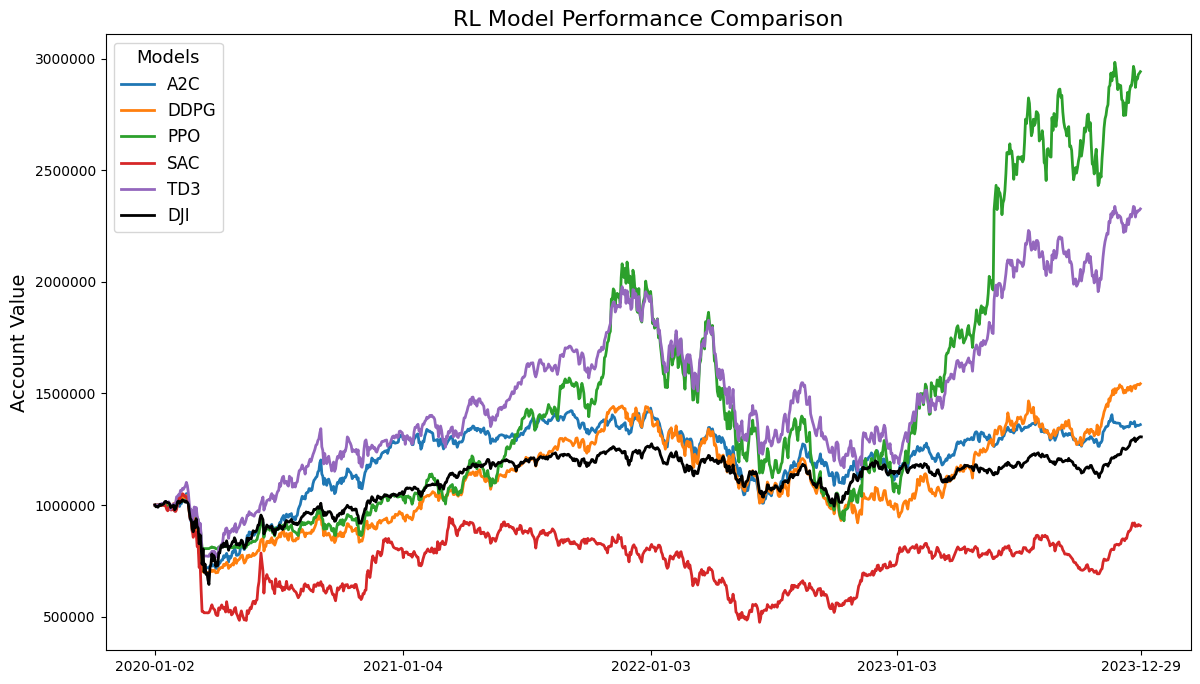

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(result.index, result['account_value_a2c'], label='A2C', linewidth=2)
plt.plot(result.index, result['account_value_ddpg'], label='DDPG', linewidth=2)
plt.plot(result.index, result['account_value_ppo'], label='PPO', linewidth=2)
plt.plot(result.index, result['account_value_sac'], label='SAC', linewidth=2)
plt.plot(result.index, result['account_value_td3'], label='TD3', linewidth=2)
#plt.plot(result.index, result['Mean Var'], label='Mean Var', linewidth=2)
plt.plot(result.index, result['close'], label='DJI',color='k',linewidth=2)
plt.xticks([0,253,253*2-1,253*3-3,253*4-7])
formatter = FuncFormatter(millions_formatter)
plt.legend(title='Models', title_fontsize='13', fontsize=12)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('RL Model Performance Comparison', fontsize=16)
plt.ylabel('Account Value', fontsize=14)
plt.show()

In [ ]:
!zip -r /content/fileresults.zip /content/results

  adding: content/results/ (stored 0%)
  adding: content/results/ppo/ (stored 0%)
  adding: content/results/ppo/events.out.tfevents.1715478265.9b639ef72dac.4425.2 (deflated 71%)
  adding: content/results/ppo/progress.csv (deflated 52%)
  adding: content/results/ddpg/ (stored 0%)
  adding: content/results/ddpg/progress.csv (deflated 39%)
  adding: content/results/ddpg/events.out.tfevents.1715477543.9b639ef72dac.4425.1 (deflated 44%)
  adding: content/results/td3/ (stored 0%)
  adding: content/results/td3/events.out.tfevents.1715478723.9b639ef72dac.4425.3 (deflated 44%)
  adding: content/results/td3/progress.csv (deflated 38%)
  adding: content/results/sac/ (stored 0%)
  adding: content/results/sac/progress.csv (deflated 42%)
  adding: content/results/sac/events.out.tfevents.1715479423.9b639ef72dac.4425.4 (deflated 49%)
  adding: content/results/a2c/ (stored 0%)
  adding: content/results/a2c/events.out.tfevents.1715477084.9b639ef72dac.4425.0 (deflated 74%)
  adding: content/results/a2c/p

In [ ]:
!zip -r /content/trained_models.zip /content/trained_models

  adding: content/trained_models/ (stored 0%)
  adding: content/trained_models/agent_ddpg.zip (stored 0%)
  adding: content/trained_models/agent_ppo.zip (stored 0%)
  adding: content/trained_models/agent_a2c.zip (stored 0%)
  adding: content/trained_models/agent_td3.zip (stored 0%)
  adding: content/trained_models/agent_sac.zip (stored 0%)


In [ ]:
results_wtemo=pd.read_csv('/content/results_wtemo.csv')

In [ ]:
results_wtemo = results_wtemo.set_index(results_wtemo.columns[0])

In [ ]:
results_wtemo.head()

,account_value_a2c,account_value_ddpg,account_value_ppo,account_value_sac,account_value_td3,Mean Var,close
date,,,,,,,
2020-01-02,1.000000e+06,1.000000e+06,1000000.000000,1.000000e+06,1.000000e+06,1.020803e+06,1000000.000000
2020-01-03,9.996373e+05,9.993876e+05,999817.747446,9.993786e+05,9.994448e+05,1.011752e+06,991897.137548
2020-01-06,9.997210e+05,9.989502e+05,999803.944049,9.994305e+05,9.995992e+05,1.014524e+06,994269.941342
2020-01-07,1.000198e+06,1.000033e+06,999798.429964,1.000433e+06,1.000799e+06,1.015519e+06,990123.556018
2020-01-08,9.991159e+05,9.979531e+05,999708.921445,9.981536e+05,9.983783e+05,1.021834e+06,995714.718514


In [ ]:
result.head()

,account_value_a2c,account_value_ddpg,account_value_ppo,account_value_sac,account_value_td3,Mean Var,close
date,,,,,,,
2020-01-02,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.020803e+06,1000000.000000
2020-01-03,9.995751e+05,9.995770e+05,9.999158e+05,9.998553e+05,9.992864e+05,1.011752e+06,991897.137548
2020-01-06,9.993468e+05,9.993250e+05,9.999454e+05,9.998806e+05,9.993311e+05,1.014523e+06,994269.941342
2020-01-07,9.993424e+05,9.988658e+05,1.000061e+06,1.000821e+06,9.990035e+05,1.015519e+06,990123.556018
2020-01-08,1.000132e+06,1.000025e+06,9.997730e+05,9.988032e+05,1.000597e+06,1.021833e+06,995714.718514


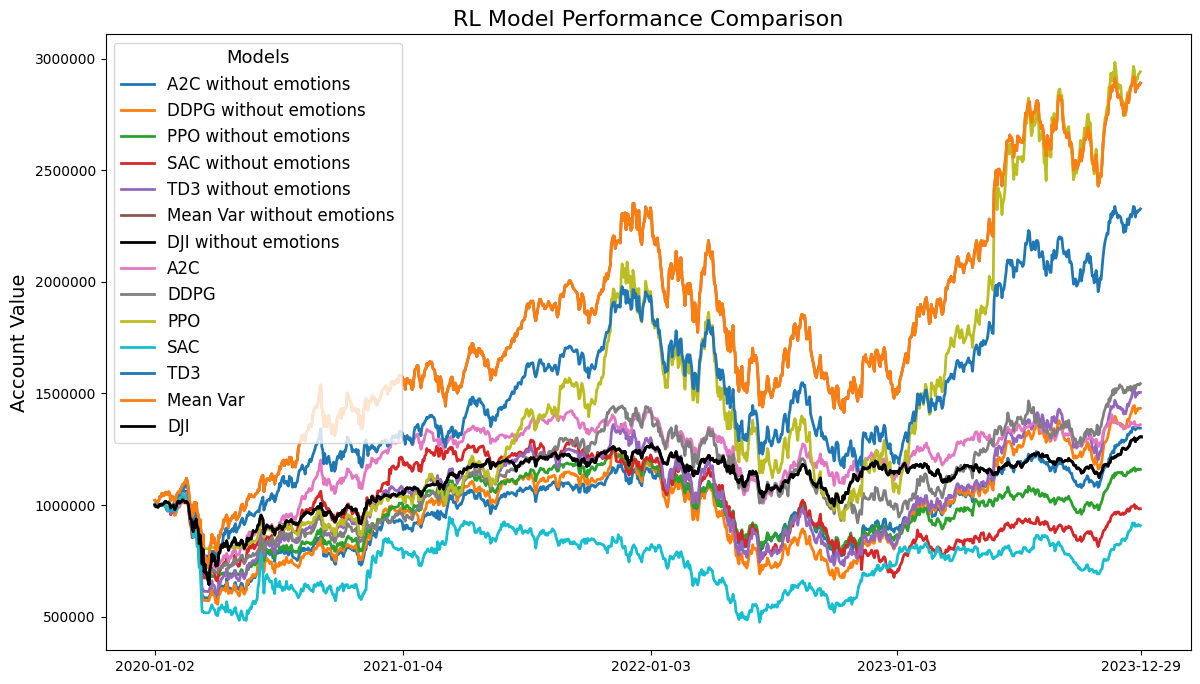

In [ ]:
plt.figure(figsize=(14, 8))

plt.plot(results_wtemo.index, results_wtemo['account_value_a2c'], label='A2C without emotions', linewidth=2)
plt.plot(results_wtemo.index, results_wtemo['account_value_ddpg'], label='DDPG without emotions', linewidth=2)
plt.plot(results_wtemo.index, results_wtemo['account_value_ppo'], label='PPO without emotions', linewidth=2)
plt.plot(results_wtemo.index, results_wtemo['account_value_sac'], label='SAC without emotions', linewidth=2)
plt.plot(results_wtemo.index, results_wtemo['account_value_td3'], label='TD3 without emotions', linewidth=2)
plt.plot(results_wtemo.index, results_wtemo['Mean Var'], label='Mean Var without emotions', linewidth=2)
plt.plot(results_wtemo.index, results_wtemo['close'], label='DJI without emotions',color='k',linewidth=2)


plt.plot(result.index, result['account_value_a2c'], label='A2C', linewidth=2)
plt.plot(result.index, result['account_value_ddpg'], label='DDPG', linewidth=2)
plt.plot(result.index, result['account_value_ppo'], label='PPO', linewidth=2)
plt.plot(result.index, result['account_value_sac'], label='SAC', linewidth=2)
plt.plot(result.index, result['account_value_td3'], label='TD3', linewidth=2)
plt.plot(result.index, result['Mean Var'], label='Mean Var', linewidth=2)
plt.plot(result.index, result['close'], label='DJI',color='k',linewidth=2)
plt.xticks([0,253,253*2-1,253*3-3,253*4-7])
formatter = FuncFormatter(millions_formatter)
plt.legend(title='Models', title_fontsize='13', fontsize=12)
plt.gca().yaxis.set_major_formatter(formatter)
plt.title('RL Model Performance Comparison', fontsize=16)
plt.ylabel('Account Value', fontsize=14)
plt.show()

In [ ]:
def millions_formatter(x, pos):
    """Convert numbers to a string with 'M' as million."""
    return f'${x / 1_000_000:.1f}M'

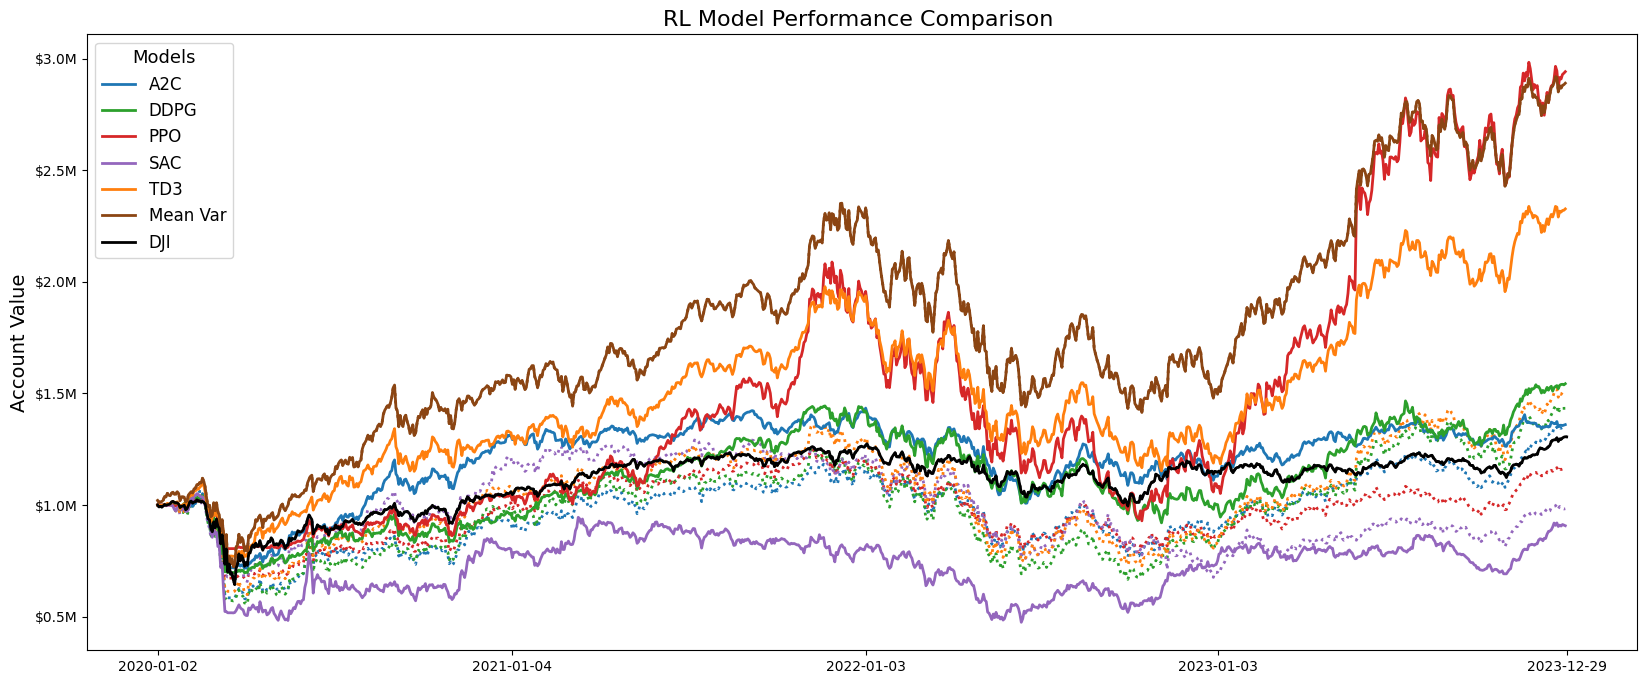

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


plt.figure(figsize=(20, 8))

# Define colors for consistency
color_a2c = '#1F77B4'  # Muted blue
color_ddpg = '#2CA02C'  # Cooked asparagus green
color_ppo = '#D62728'  # Brick red
color_sac = '#9467BD'  # Muted purple
color_td3 = '#FF7F0E'  # Safety orange
color_mean_var = '#8B4513'  # Saddle brown (for Mean Var)
color_dji = '#000000'  # Black (for DJI)

# Plotting results_wtemo with dashed lines
plt.plot(results_wtemo.index, results_wtemo['account_value_a2c'], color=color_a2c, linewidth=2, linestyle='dotted')
plt.plot(results_wtemo.index, results_wtemo['account_value_ddpg'], color=color_ddpg, linewidth=2, linestyle='dotted')
plt.plot(results_wtemo.index, results_wtemo['account_value_ppo'], color=color_ppo, linewidth=2, linestyle='dotted')
plt.plot(results_wtemo.index, results_wtemo['account_value_sac'], color=color_sac, linewidth=2, linestyle='dotted')
plt.plot(results_wtemo.index, results_wtemo['account_value_td3'], color=color_td3, linewidth=2, linestyle='dotted')
plt.plot(results_wtemo.index, results_wtemo['Mean Var'], color=color_mean_var, linewidth=2, linestyle='dotted')
plt.plot(results_wtemo.index, results_wtemo['close'], color=color_dji, linewidth=2, linestyle='dotted')

# Plotting result with solid lines
plt.plot(result.index, result['account_value_a2c'], label='A2C', color=color_a2c, linewidth=2)
plt.plot(result.index, result['account_value_ddpg'], label='DDPG', color=color_ddpg, linewidth=2)
plt.plot(result.index, result['account_value_ppo'], label='PPO', color=color_ppo, linewidth=2)
plt.plot(result.index, result['account_value_sac'], label='SAC', color=color_sac, linewidth=2)
plt.plot(result.index, result['account_value_td3'], label='TD3', color=color_td3, linewidth=2)
plt.plot(result.index, result['Mean Var'], label='Mean Var', color=color_mean_var, linewidth=2)
plt.plot(result.index, result['close'], label='DJI', color=color_dji, linewidth=2)

# Customizing x-ticks for clarity
plt.xticks([0, 253, 253*2-1, 253*3-3, 253*4-7])

# Adding a formatter for the y-axis
formatter = FuncFormatter(millions_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Adding legend, title and labels
plt.legend(title='Models', title_fontsize='13', fontsize=12)
plt.title('RL Model Performance Comparison ', fontsize=16)
plt.ylabel('Account Value', fontsize=14)

# Show the plot
plt.show()


In [ ]:
import pandas as pd

# Assuming results_wtemo and result are already defined DataFrames
# Here's how you could calculate max, min, and final values for each account type

# Define the columns of interest based on your data description
columns = [
    'account_value_a2c', 'account_value_ddpg', 'account_value_ppo',
    'account_value_sac', 'account_value_td3', 'Mean Var', 'close'
]

# Function to compute max, min, and final value for each column in a DataFrame
def compute_metrics(df, columns):
    metrics = {}
    for col in columns:
        metrics[col] = {
            'max': df[col].max(),
            'min': df[col].min(),
            'final': df[col].iloc[-2]
        }
    return metrics

# Compute metrics for results_wtemo
metrics_wtemo = compute_metrics(results_wtemo, columns)

# Compute metrics for result
metrics_result = compute_metrics(result, columns)

# Output the results
print("Metrics for results_wtemo:")
for k, v in metrics_wtemo.items():
    print(f"{k}: Max = {v['max']}, Min = {v['min']}, Final = {v['final']}")

print("\nMetrics for result:")
for k, v in metrics_result.items():
    print(f"{k}: Max = {v['max']}, Min = {v['min']}, Final = {v['final']}")


Metrics for results_wtemo:
account_value_a2c: Max = 1349856.8888225537, Min = 576758.8719458685, Final = 1344732.7305049878
account_value_ddpg: Max = 1445747.0224754785, Min = 554862.8100744489, Final = 1433522.1462948297
account_value_ppo: Max = 1250572.0621167456, Min = 671632.5419999358, Final = 1159688.791632531
account_value_sac: Max = 1291987.511226677, Min = 657506.6445853389, Final = 983601.1591024252
account_value_td3: Max = 1518512.8749189605, Min = 598117.4900132748, Final = 1505299.3249311673
Mean Var: Max = 2920148.4984564697, Min = 722855.0759250217, Final = 2890714.946559464
close: Max = 1306257.9858527528, Min = 644014.6173157034, Final = 1306257.9858527528

Metrics for result:
account_value_a2c: Max = 1434573.9952937088, Min = 715441.4244902618, Final = 1360408.342103096
account_value_ddpg: Max = 1543716.2164937125, Min = 696038.4519070825, Final = 1543716.2164937125
account_value_ppo: Max = 2984424.768134226, Min = 803332.8937753877, Final = 2942377.9879676
account_va

In [ ]:
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": [0]
    "buy_cost_pct": [0.001]
    "sell_cost_pct": 0.01
    "state_space": 101
    "action_space": 5,
    "reward_scaling": 1e-4

In [ ]:
1 + 2 * len(trade['tic'].unique()) + len(INDICATORS) * len(trade['tic'].unique())

101

In [ ]:
len(trade['tic'].unique())*0.001

0.01